In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model
import glob

In [ ]:
SIZE=256
img_data=[]


In [ ]:
path = glob.glob("/content/drive/MyDrive/images binary 500/*.tif")
path.sort()

In [ ]:
train_images = []


for img_path in path:
  img = cv2.imread(img_path,1)
  img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_NEAREST)
  train_images.append(img_to_array(img))

In [ ]:
img_array = np.reshape(train_images, (len(train_images), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.



In [ ]:
#Convolutional block to be used in autoencoder and U-Net
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x


In [ ]:
#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


In [ ]:
#Decoder block for autoencoder (no skip connections)
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x


In [ ]:
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    encoded = conv_block(p4, 1024) #Bridge

    return encoded

In [ ]:
#Decoder for Autoencoder ONLY.
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)

    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

#Use encoder and decoder blocks to build the autoencoder.
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)


In [ ]:
model=build_autoencoder(img.shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                             

In [ ]:

model.fit(img_array, img_array,
        epochs=50,
        shuffle=True)


Epoch 1/50


In [ ]:
model.save('/content/drive/MyDrive/0_epoch_weights/autoencoder_mito_500imgs_100epochs.h5')


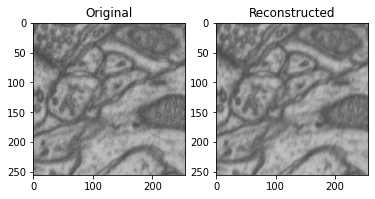

In [ ]:
#test on a few images
#Load the model
from keras.models import load_model
autoencoder_model = load_model("/content/drive/MyDrive/0_epoch_weights/autoencoder_mito_1980imgs_100epochs.h5", compile=False)

import random
num=random.randint(0, len(img_array)-1)
test_img = np.expand_dims(img_array[num], axis=0)
pred = autoencoder_model.predict(test_img)

plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('Reconstructed')
plt.show()

In [ ]:
#Decoder block for unet
#skip features gets input from encoder for concatenation
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    print(model.summary())
    return model

In [ ]:
from keras.models import load_model


In [ ]:
autoencoder_model = load_model("/content/drive/MyDrive/0_epoch_weights/autoencoder_mito_1980imgs_100epochs.h5", compile=False)

#Now define encoder model only, without the decoder part.
input_shape = (256, 256, 3)
input_img = Input(shape=input_shape)

encoder = build_encoder(input_img)
encoder_model = Model(input_img, encoder)
print(encoder_model.summary())

num_encoder_layers = len(encoder_model.layers) #35 layers in our encoder.

#Get weights for the 35 layers from trained autoencoder model and assign to our new encoder model
for l1, l2 in zip(encoder_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_18 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 256, 256, 64)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_19 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                          

In [ ]:
#Verify if the weights are the same between autoencoder and encoder only models.
autoencoder_weights = autoencoder_model.get_weights()[0][1]
encoder_weights = encoder_model.get_weights()[0][1]


In [ ]:
#Save encoder weights for future comparison
np.save('/content/drive/MyDrive/0_epoch_weights/pretrained_encoder-weights.npy', encoder_weights )


In [ ]:
#Now let us define a Unet with same encoder part as out autoencoder.
#Then load weights from the original autoencoder for the first 35 layers (encoder)
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape)

#Print layer names for each model to verify the layers....
#First 35 layers should be the same in both models.
unet_layer_names=[]
for layer in unet_model.layers:
    unet_layer_names.append(layer.name)

autoencoder_layer_names = []
for layer in autoencoder_model.layers:
    autoencoder_layer_names.append(layer.name)

#Make sure the first 35 layers are the same. Remember that the exct names of the layers will be different.
###########

#Set weights to encoder part of the U-net (first 35 layers)
for l1, l2 in zip(unet_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 256, 256, 64  256        ['conv2d_29[0][0]']              
 ormalization)                  )                                                             

In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.5 MB/s 


In [ ]:
# from keras.optimizers import Adam
import segmentation_models as sm
unet_model.compile('adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
#unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()
print(unet_model.output_shape)

unet_model.save('./unet_model_weights.h5')


Segmentation Models: using `keras` framework.
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 256, 256, 64  256        ['conv2d_29[0][0]']              
 ormalization)                  )               

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
#########################################################################
#Load data for U-net training.
#################################################################
import os

In [ ]:
SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


In [ ]:
path = glob.glob("/content/drive/MyDrive/images binary 500/*.tif")
path.sort()

In [ ]:
print(len(path))

500


In [ ]:
train_images = []


for img_path in path:
  img = cv2.imread(img_path,1)
  img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_NEAREST)
  image_dataset.append(img)

In [ ]:
path1 = glob.glob("/content/drive/MyDrive/masksbinary500/*.tif")
path1.sort()

In [ ]:
print(len(path1))

500


In [ ]:
train_masks = []
for img_path1 in path1:
  mask = cv2.imread(img_path1,0)
  mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
  mask_dataset.append(mask)

In [ ]:

#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)), 3) /255.


In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)


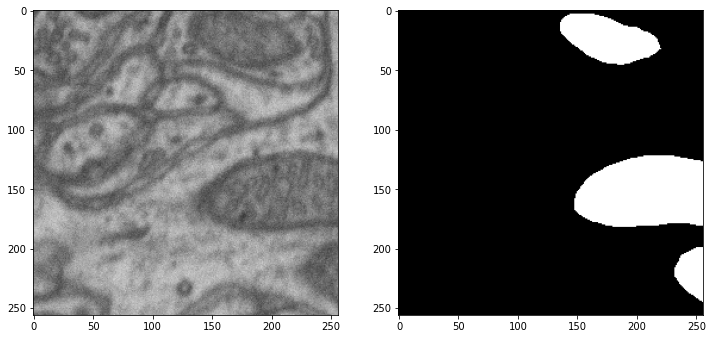

In [ ]:

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
#######################################################################
#Load unet model and load pretrained weights
# from models import build_autoencoder, build_encoder, build_unet
# from keras.optimizers import Adam
import segmentation_models as sm

input_shape = (256, 256, 3)
random_wt_unet_model = build_unet(input_shape)

random_wt_unet_model_weights = random_wt_unet_model.get_weights()[0][1]

pre_trained_unet_model = build_unet(input_shape)
pre_trained_unet_model.load_weights('/content/drive/MyDrive/0_epoch_weights/unet_model_weights.h5')
pre_trained_unet_model_weights = pre_trained_unet_model.get_weights()[0][1]

#Load previously saved pretrained encoder weights just for comparison with the unet weights (Sanity check)
pretrained_encoder_wts = np.load('/content/drive/MyDrive/0_epoch_weights/pretrained_encoder-weights.npy')

if pre_trained_unet_model_weights.all() == pretrained_encoder_wts.all():
    print("Both weights are identical")
else:
    print("Something wrong, weghts are different")


#Compile both models, one with random weights and the other with pretrained
random_wt_unet_model.compile('adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
pre_trained_unet_model.compile('adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_46 (BatchN  (None, 256, 256, 64  256        ['conv2d_48[0][0]']              
 ormalization)                  )                                                             

In [ ]:
#Train the model
batch_size=16

random_wt_unet_model_history = random_wt_unet_model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=150)

Epoch 1/150
25/25 [==============================] - 2820s 113s/step - loss: 0.8347 - iou_score: 0.2310 - val_loss: 2.7222 - val_iou_score: 0.0595
Epoch 2/150
25/25 [==============================] - 2765s 111s/step - loss: 0.5791 - iou_score: 0.4536 - val_loss: 3.8575 - val_iou_score: 0.0630
Epoch 3/150
25/25 [==============================] - 2791s 112s/step - loss: 0.4198 - iou_score: 0.6064 - val_loss: 4.7402 - val_iou_score: 0.0498
Epoch 4/150
25/25 [==============================] - 2809s 112s/step - loss: 0.3261 - iou_score: 0.6979 - val_loss: 1.0371 - val_iou_score: 0.0486
Epoch 5/150
13/25 [==============>...............] - ETA: 21:24 - loss: 0.2674 - iou_score: 0.7547

In [ ]:
pre_trained_unet_model_history = pre_trained_unet_model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=150)


In [ ]:

random_wt_unet_model.save('/content/drive/MyDrive/0_epoch_weights/random_wt_unet_model_50epochs.h5')


In [ ]:
pre_trained_unet_model.save('/content/drive/MyDrive/0_epoch_weights/pre_trained_unet_model_50epochs.h5')


In [ ]:
history = random_wt_unet_model_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
history1 = pre_trained_unet_model_history

#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
random_wt_unet_model = load_model('./random_wt_unet_model_50epochs.h5',compile=False)
                      # custom_objects={'categorical_focal_jaccard_loss': sm.losses.sm.losses.categorical_focal_jaccard_loss,
                      #                 'iou_score':sm.metrics.IOUScore(threshold=0.5)})

pre_trained_unet_model = load_model('pre_trained_unet_model_50epochs.h5', compile=False)

my_model = random_wt_unet_model
# my_model = pre_trained_unet_model

import random
test_img_number = random.randint(0, X_test.shape[0]-1)
#test_img_number = 119
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (my_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average

import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (my_model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

In [ ]:
!pip install pyyaml h5py